<a href="https://colab.research.google.com/github/patjiang/batchnmr/blob/main/batchNMRTutorialw_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Begin by importing data

Because NMR files and the overall file format in general is in a nested directory-type format, you need to zip your files while they are in this format:

```bash
file_dir/
├── sample name/condition (1)
├    ├── key (1)
├    └── key (2)
├── sample name/condition (2)
├    ├── key (1)
├    └── key (2)
├── sample name/condition (3)
├    ├── key (1)
├    └── key (2)
└──sample name/condition (4)
     ├── key (1)
     └── key (2)
```

## For Example:
```bash
brain_run_12-13-23/
├──  Brain organoid - Control
├    ├── lipid
├    └── water
└──  Brain organoid - microglia
     ├── lipid
     └── water
```
Then, within each "key" folder, you should have the actual NMR file scans, like:

```bash
water/
  ├──experiment name1
  ├   └── 10
  ├      ├── acqus
  ├      ├── fid
  ├      ├── acqu
  ├      └── pdata
  ├           └── 1
  ├               ├── 1r
  ├               ├── 1i
  ├               ├── proc
  ├               └── procs
  └──experiment name2
      └── 10
         ├── acqus
         ├── fid
         ├── acqu
         └── pdata
              └── 1
                  ├── 1r
                  ├── 1i
                  ├── proc
                  └── procs
```


In [1]:
#@title import dependencies and set up venv
import os
from matplotlib import pyplot as plt
import numpy as np
import math
import time

os.system("pip install git+https://github.com/NMRPy/nmrpy.git@4aeb0b738b72743900b45cfc9e7f8caaa3381b20")
os.system("pip install PyWavelets")
import nmrpy
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib
from matplotlib import colormaps
import pywt

def import_data(file_dir, key):
    init_arr = os.listdir(f"./{file_dir}/")

    exp_names = []
    for i in range(len(init_arr)):
        if("." not in init_arr[i]):
            exp_names.append(init_arr[i])

    fidarr_dict = {}
    for j in range(len(exp_names)):
        file_arr = os.listdir(f"./{file_dir}/{exp_names[j]}/{key}/")
        temp_dict = {}
        for k in range(len(file_arr)):
            if("." not in file_arr[k]):
                temp_dict[file_arr[k]] = nmrpy.from_path(fid_path=f"./{file_dir}/{exp_names[j]}/{key}/{file_arr[k]}")
                print(f"./{file_dir}/{exp_names[j]}/{key}/{file_arr[k]}")
        fidarr_dict[f"{exp_names[j]}"] = temp_dict

    return fidarr_dict

def preprocess(fid_array: nmrpy.data_objects.FidArray):
    start_time = time.time()
    print("EMHZ, Fourier Transform")
    em_ft(fid_array)
    print("Finished!\nPhase Correct, Real, Norm Fids:\n")
    pc(fid_array)
    print("Finished!")
    print("-- %5.5f s Run Time --" % (time.time() - start_time))

def em_ft(fid_array: nmrpy.data_objects.FidArray):
    fid_array.emhz_fids();
    fid_array.ft_fids();

def pc(fid_array: nmrpy.data_objects.FidArray):
    fid_array.phase_correct_fids(verbose = False);
    fid_array.real_fids();
    fid_array.norm_fids();

def generate_idx(n, arr):
    m = len(arr)
    out = []
    for i in range(n):
        n = str(np.random.randint(0,m))
        while(n in out):
            n = str(np.random.randint(0,m))
        s = str(n)
        while(len(s) != len(str(m))):
            s = "0" + s
        out.append(s)
    return out

def avg_spectra(fidArray: nmrpy.data_objects.FidArray, n):
    dataOut = 0
    ppmOut = 0
    indx_array = generate_idx(n, fidArray.data)
    #print(indx_array)
    for i in range(n):
        dataOut = dataOut + fidArray.get_fid(f"fid{indx_array[i]}").data
        ppmOut = ppmOut + fidArray.get_fid(f"fid{indx_array[i]}")._ppm
    dataOut = dataOut / n
    ppmOut = ppmOut / n
    return dataOut, ppmOut

def fidDictViz(dataDict):
    if type(dataDict) is dict:
        for i in dataDict.keys():
            print(f"{i}:")
            print(f"\t{fidDictViz(dataDict[i])}")
    #type(a) is nmrpy.data_objects.FidArray
        return ""
    elif type(dataDict) is np.ndarray:
        print(f"\t{dataDict}")
        return ""
    else:
        if(len(dataDict.get_fids()) > 10):
            print(f"\t{[f.id for f in dataDict.get_fids()[1:5]]}, {len(dataDict.get_fids()) - 4} keys omitted")
        else:
            print(f"\t{[f.id for f in dataDict.get_fids()]}")
        return ""

def preproc_max_inDict(dataDict):
    for i in dataDict.keys():
        tAvg = {}
        tPpm = {}
        for j in dataDict[i].keys():
            preprocess(dataDict[i][j])
            tTuple = avg_spectra(dataDict[i][j], len(dataDict[i][j].data))
            tAvg[j] = tTuple[0]
            tPpm[j] = tTuple[1]
        dataDict[i]["max_avgs"] = tAvg
        dataDict[i]["max_ppms"] = tPpm

def plotmaxDict(dataDict, samples, cmap = 'viridis'):
    map = matplotlib.colormaps[cmap].resampled(samples)
    counter = 0
    for i in dataDict.keys():
        for j in dataDict[i]["max_avgs"].keys():
            plt.plot(dataDict[i]["max_ppms"][j], dataDict[i]["max_avgs"][j],
                     c = map.colors[counter],
                     label = f"{i}_{j}")
            counter += 1
    plt.legend()
    plt.xlim(left = -1, right = 6)

def shift_lip(fid_arr, ppm, verbose):
  pos = np.where(fid_arr == max(fid_arr))
  top = np.where((ppm == 8 + min([abs(x - 8) for x in ppm])) | (ppm == 8 - min([abs(x - 8) for x in ppm])))
  shift = True
  if(pos != top):
      if verbose:
          print(f"\tPosition Not Equal: \tfidpos: {pos[0][0]}\tppmpos: {top[0][0]}, \tppm value: {ppm[top[0][0]]}\n")
  else:
      if verbose:
          print(f"\tPosition Equal: \tfidpos: {pos[0][0]}\tppmpos: {top[0][0]}, \tppm value: {ppm[top[0][0]]}\n")
      shift = False
      newFID = fid_arr

  if shift:
      if verbose:
          print("\tShifting fid such that the highest frequency peak is also closest to 8\n")
      diff = top[0][0] - pos[0][0]
      if verbose:
          print(f"\tShift amount = {diff}\n")
      if (diff > (len(fid_arr)/10)):
          if verbose:
              print("\tToo much shift. Alignment Failed\n")
          return "emp","ty"
      else:
          newFID = np.roll(fid_arr, diff)
          shift_lip(newFID, ppm, verbose = verbose)

  #set min ppm to 0

  ppmval = ppm[top]

  new_ppm = 8 - ppmval + ppm

  pos = np.where(newFID == max(newFID))
  top = np.where((new_ppm == 8 + min([abs(x-8) for x in new_ppm])) | (new_ppm == 8 - min([abs(x-8) for x in new_ppm])))

  if verbose:
      print(f"final values: \tfidpos: {pos[0][0]}\tppmpos: {top[0][0]}, \tppm value: {new_ppm[top[0][0]]}\n")

  return newFID, new_ppm

def shift_tms(fid_arr, ppm, verbose):
    pos = np.where(fid_arr == max(fid_arr))
    zero = np.where((ppm == min(abs(ppm))) | (ppm == -1 * min(abs(ppm))))
    shift = True
    if(pos != zero):
        if verbose:
            print(f"\tPosition Not Equal: \tfidpos: {pos[0][0]}\tppmpos: {zero[0][0]}, \tppm value: {ppm[zero[0][0]]}\n")
    else:
        if verbose:
            print(f"\tPosition Equal: \tfidpos: {pos[0][0]}\tppmpos: {zero[0][0]}, \tppm value: {ppm[zero[0][0]]}\n")
        shift = False
        newFID = fid_arr

    if shift:
        if verbose:
            print("\tShifting fid such that the highest frequency peak is also closest to 0\n")
        diff = zero[0][0] - pos[0][0]
        if verbose:
            print(f"\tShift amount = {diff}\n")
        if (diff > (len(fid_arr)/10)):
            if verbose:
                print("\tToo much shift. Alignment Failed\n")
            return "emp","ty"
        else:
            newFID = np.roll(fid_arr, diff)
            shift_tms(newFID, ppm, verbose = verbose)

    #set min ppm to 0

    ppmval = ppm[zero]

    new_ppm = ppm - ppmval

    pos = np.where(newFID == max(newFID))
    zero = np.where((new_ppm == min(abs(new_ppm))) | (new_ppm == -1 * min(abs(new_ppm))))

    if verbose:
        print(f"final values: \tfidpos: {pos[0][0]}\tppmpos: {zero[0][0]}, \tppm value: {new_ppm[zero[0][0]]}\n")

    return newFID, new_ppm

def rem_invalid_shift_dict(shift, ppmSh):
    nshift = dict(shift)
    nppmSh = dict(ppmSh)
    for i in shift.keys():
        if type(nshift[i]) == str:
            del nshift[i]
            del nppmSh[i]
    return nshift, nppmSh

def calc_shift_dict(dataDict, typ, verbose = True):
    for i in dataDict.keys():
        tshift = {}
        tppms = {}
        for j in dataDict[i]["max_avgs"].keys():
          if(typ == "water"):
            tTuple = (shift_tms(dataDict[i]["max_avgs"][j], dataDict[i]["max_ppms"][j], verbose = verbose))
            tshift[j] = tTuple[0]
            tppms[j] = tTuple[1]
          elif(typ == "lipid"):
            tTuple = (shift_lip(dataDict[i]["max_avgs"][j], dataDict[i]["max_ppms"][j], verbose = verbose))
            tshift[j] = tTuple[0]
            tppms[j] = tTuple[1]
          else:
            print("Invalid Type")
        tshift, tppms = rem_invalid_shift_dict(tshift, tppms)
        dataDict[i]["shift"] = tshift
        dataDict[i]["ppmSh"] = tppms

def plotshiftDict(dataDict, samples, cmap = 'viridis'):
    map = matplotlib.colormaps[cmap].resampled(samples)
    counter = 0
    for i in dataDict.keys():
        for j in dataDict[i]["shift"].keys():
            plt.plot(dataDict[i]["ppmSh"][j], dataDict[i]["shift"][j],
                     c = map.colors[counter],
                     label = f"{i}_{j}")
            counter += 1
    plt.legend()
    plt.xlim(left = -1, right = 6)


def closer_to_zero(spec, ppm):
    cond = False
    max_index = np.where(spec == max(spec))[0][0]
    if(abs(ppm[max_index]) < (1 - abs(ppm[max_index]))):
        cond = True
    return cond

def focus_ppm_region(spec, ppm):
    #truncate TMS peak and water suppression peak
    tempSpec = np.array(spec)
    index_of_TMS = np.where(tempSpec == max(tempSpec))[0][0]
    index_of_water = np.where(tempSpec == min(spec))[0][0]
    return spec[index_of_water: index_of_TMS], ppm[index_of_water:index_of_TMS]

def repad(spec, ppm, n, max = True):
    tspec = spec
    tppm = ppm
    if max:
        if(len(tspec) < n):
            tspec = np.pad(tspec, (0, n - len(tspec)))
            tppm = np.pad(tppm, (0, n - len(tppm)))
    else:
        if(len(spec) > n):
            tspec = tspec[:(n - len(tspec))]
            tppm = tppm[:(n - len(tppm))]

    return tspec, tppm


def truncate_dict(dataDict, bymax = True):
    if(bymax):
        nlen = 0
    else:
        nlen = math.inf
    for i in dataDict.keys():
        trun = {}
        tppm = {}
        for j in dataDict[i]["shift"]:
            #print(f"Truncating shifted spectra in {j}")
            trun[j] = dataDict[i]["shift"][j]
            tppm[j] = dataDict[i]["ppmSh"][j]
            while(closer_to_zero(trun[j], tppm[j])):
                tTuple = focus_ppm_region(trun[j], tppm[j])
                trun[j] = tTuple[0]
                tppm[j] = tTuple[1]
            if(len(trun[j]) > nlen) and bymax:
                nlen = len(trun[j])
            elif(len(trun[j]) < nlen) and not bymax:
                nlen = len(trun[j])
        dataDict[i]["truncated"] = trun
        dataDict[i]["tPpm"] = tppm
    #print(nlen)

    for i in dataDict.keys():
        for k in dataDict[i]["truncated"].keys():
            dataDict[i]["truncated"][k], dataDict[i]["tPpm"][k] = repad(dataDict[i]["truncated"][k], dataDict[i]["tPpm"][k], n = nlen, max = bymax)
            #print(len(dataDict[i]["truncated"][k]), len(dataDict[i]["tPpm"][k]))

def plotTruncdict(dataDict, samples, cmap = 'viridis'):
    map = matplotlib.colormaps[cmap].resampled(samples)
    counter = 0
    for i in dataDict.keys():
        for j in dataDict[i]["truncated"].keys():
            #print(len(dataDict[i]["tPpm"][j]), len(dataDict[i]["tPpm"][j]))
            plt.plot(dataDict[i]["tPpm"][j], dataDict[i]["truncated"][j],
                     c = map.colors[counter],
                     label = f"{i}_{j}")
            counter += 1
    plt.legend()

In [2]:
#@title Import data and unzip into colab environment. This may take a while so please let it run in the background!
from google.colab import files

uploader =  files.upload()
zipfile = uploader[list(uploader.keys())[0]]

with open("input.zip","wb") as out: out.write(zipfile)

!unzip -q input.zip
!rm input.zip
!rm -r __MACOSX

Saving AAStandards-test.zip to AAStandards-test.zip


In [4]:
#@title Import and preprocess into the working environment
dir = "AAStandards-test" #@param {type:"string"}
key = "buf" #@param {type:"string"}
dataDict = import_data(dir, key)
preproc_max_inDict(dataDict)

Not NMRPy data file.
Attempting Bruker
./AAStandards-test/1mm/buf/1mm_14
Not NMRPy data file.
Attempting Bruker
./AAStandards-test/1mm/buf/1mm_11
Not NMRPy data file.
Attempting Bruker
./AAStandards-test/1mm/buf/1mm_12
Not NMRPy data file.
Attempting Bruker
./AAStandards-test/1mm/buf/1mm_10
Not NMRPy data file.
Attempting Bruker
./AAStandards-test/1mm/buf/1mm_13
Not NMRPy data file.
Attempting Bruker
./AAStandards-test/1_5mm/buf/1_5mm_12
Not NMRPy data file.
Attempting Bruker
./AAStandards-test/1_5mm/buf/1_5mm_11
Not NMRPy data file.
Attempting Bruker
./AAStandards-test/1_5mm/buf/1_5mm_13
Not NMRPy data file.
Attempting Bruker
./AAStandards-test/1_5mm/buf/1_5mm_14
Not NMRPy data file.
Attempting Bruker
./AAStandards-test/1_5mm/buf/1_5mm_10
Not NMRPy data file.
Attempting Bruker
./AAStandards-test/2mm/buf/2mm_11
Not NMRPy data file.
Attempting Bruker
./AAStandards-test/2mm/buf/2mm_12
Not NMRPy data file.
Attempting Bruker
./AAStandards-test/2mm/buf/2mm_10
Not NMRPy data file.
Attempting

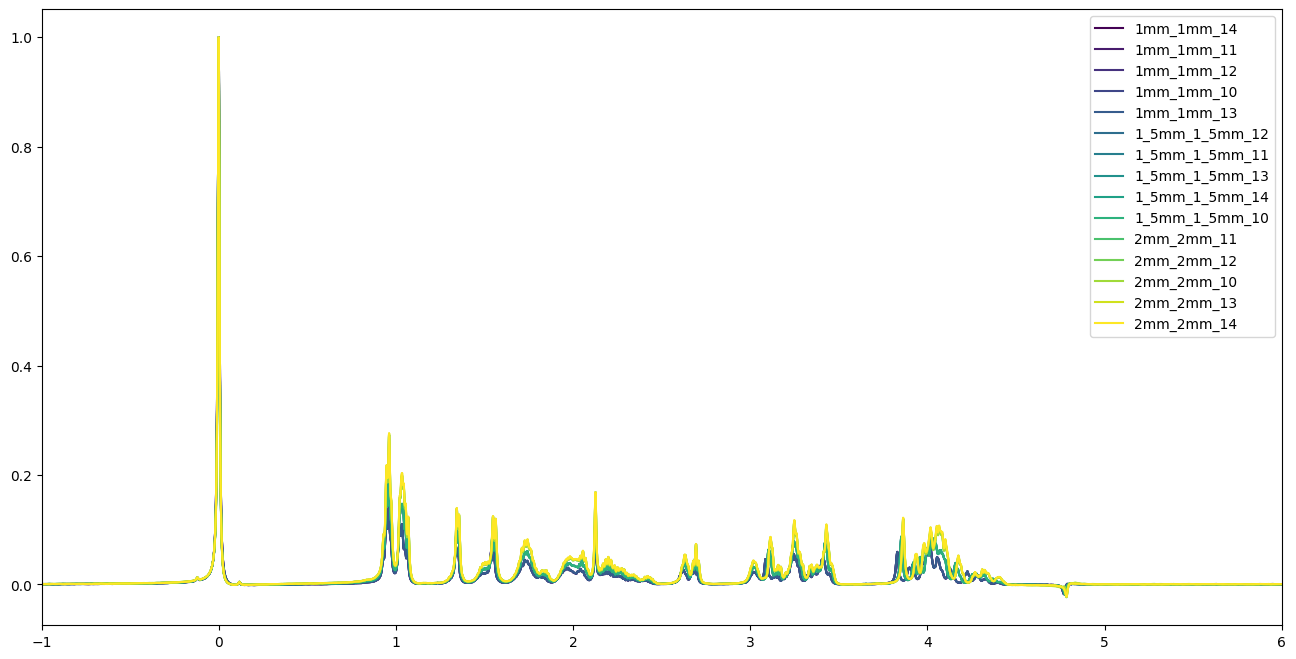

In [5]:
#@title Plot the figures
plt.figure(figsize=(16,8))
plotmaxDict(dataDict, 15)
plt.show()

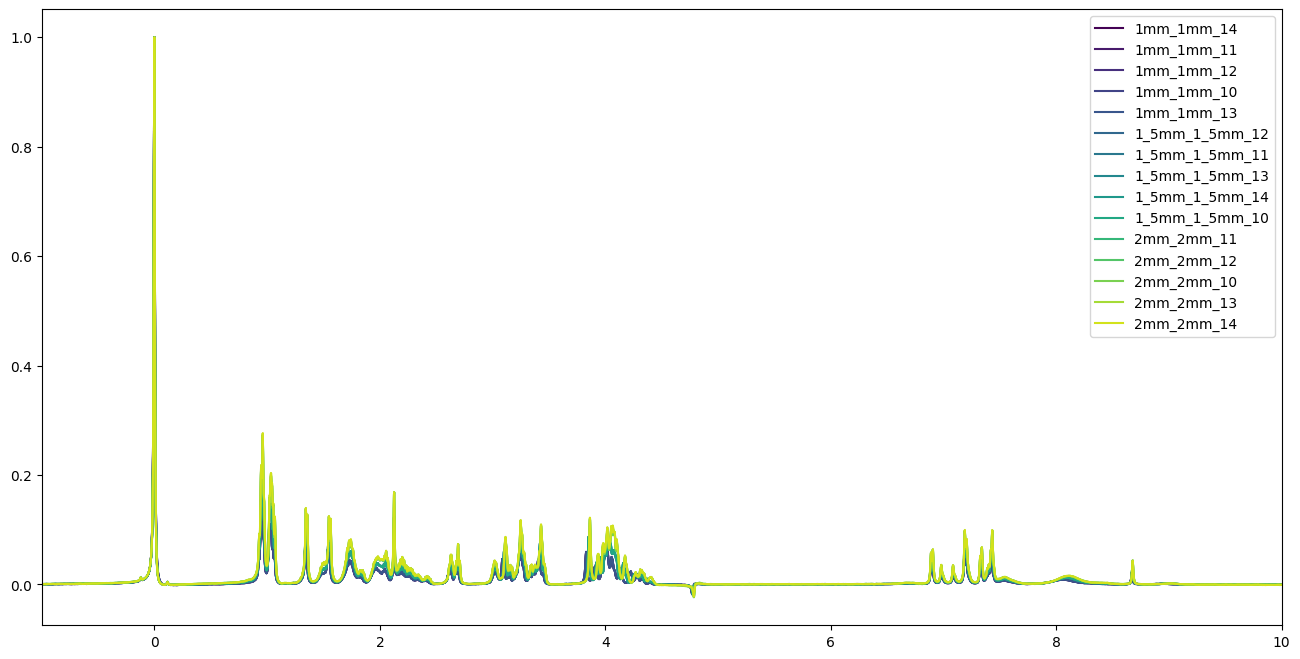

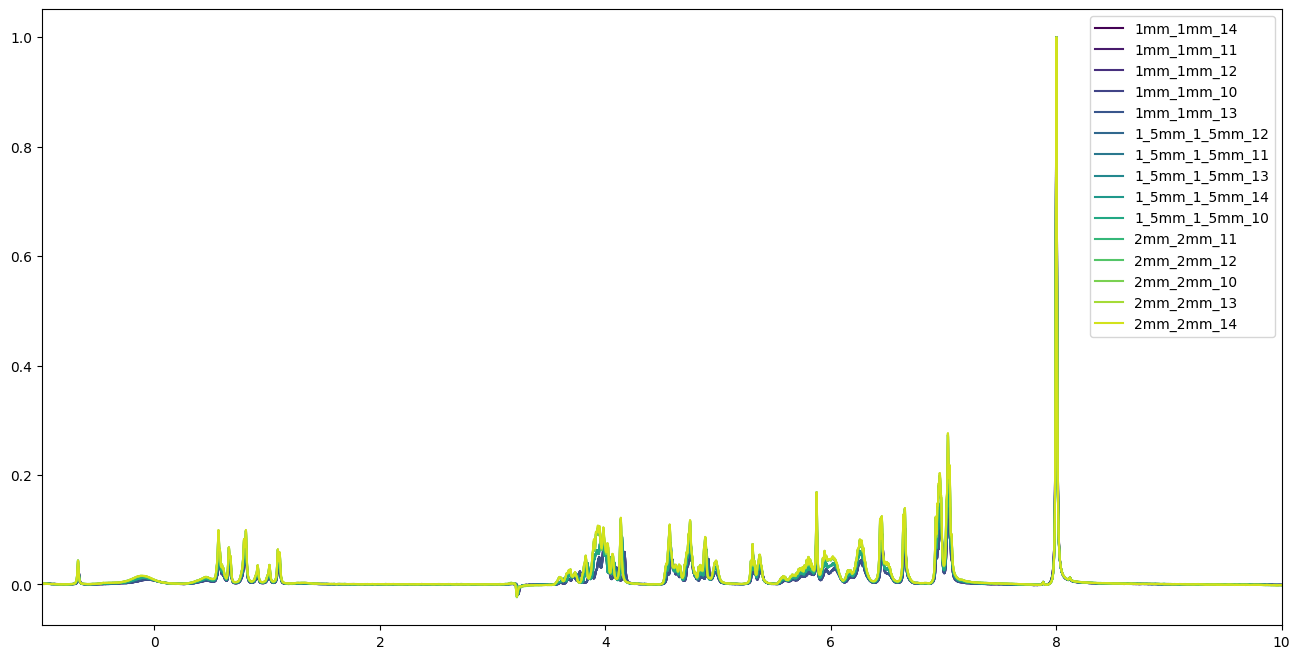

In [6]:
import copy
dD = copy.deepcopy(dataDict)
plt.figure(figsize=(16,8))
plotmaxDict(dD, 16)
plt.xlim(-1, 10)
plt.show()
for i in dD.keys():
  keylist = dD[i]["max_ppms"].keys()
  for j in keylist:
    tarr = dD[i]["max_ppms"][j]
    narr = np.array([(8-x) for x in tarr])
    dD[i]["max_ppms"][j] = narr
plt.figure(figsize=(16,8))
plotmaxDict(dD, 16)
plt.xlim(-1, 10)
plt.show()

In [ ]:
#@title DANGER DO NOT RUN
aware = True #@param {type: "boolean"}
sample_num = 8 #@param {type: "integer"}
include_limit = True #@param {type:"boolean"}
xleft_limit = -1 #@param {type:"integer"}
xright_limit = 10 #@param {type:"integer"}

title = "pseudo lip sample" #@param {type:"string"}
title_size = 16 #@param {type:"integer"}
xlabel = "ppm" #@param {type:"string"}
ylabel = "arbitrary intensity" #@param {type:"string"}
nmr_type = "lipid" #@param ['water', 'lipid']

if aware:
  calc_shift_dict(dD, nmr_type, verbose = True)
  plt.figure(figsize=(16,8))
  plotshiftDict(dD, sample_num, cmap = 'plasma')
  if(include_limit):
    plt.xlim(xleft_limit,xright_limit)

  plt.title(title, fontsize = title_size)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()



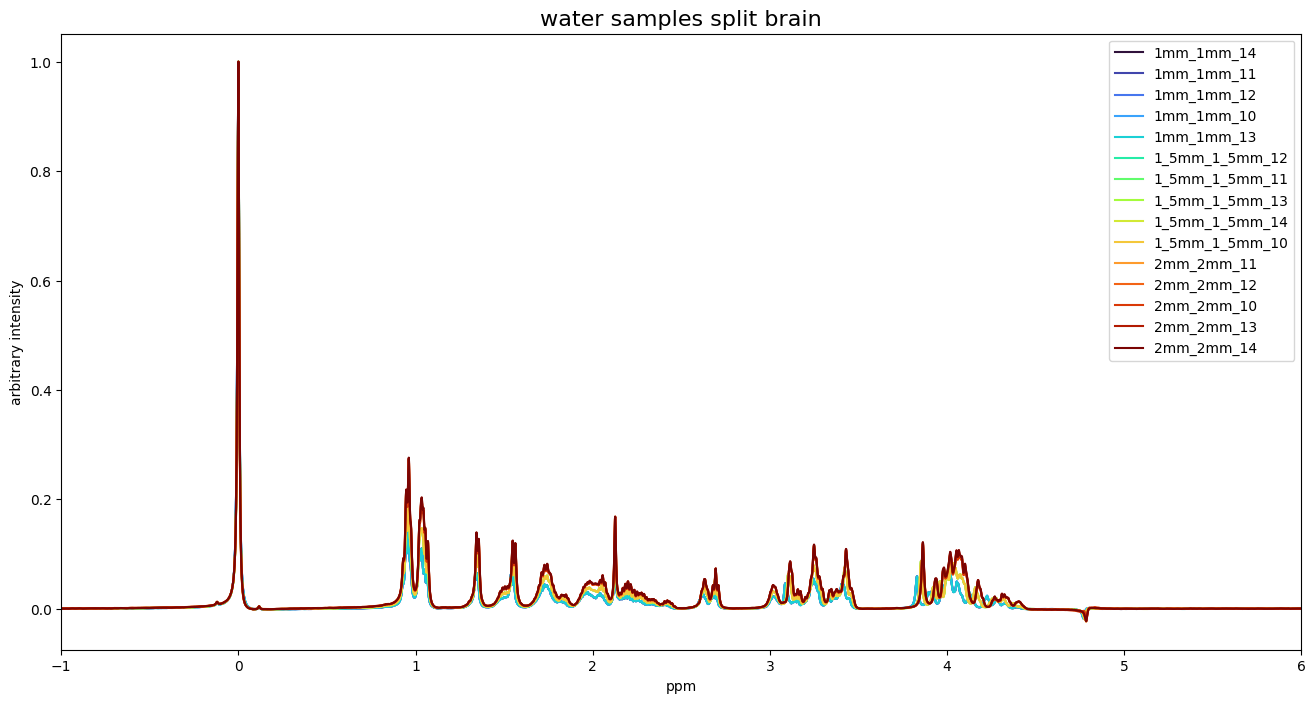

In [7]:
#@title Shift the spectra and plot
colormap = 'turbo' #@param {type:"string"}
sample_num = 15 #@param {type: "integer"}
include_limit = False #@param {type:"boolean"}
xleft_limit = 2 #@param {type:"integer"}
xright_limit = 4 #@param {type:"integer"}

title = "water samples split brain" #@param {type:"string"}
title_size = 16 #@param {type:"integer"}
xlabel = "ppm" #@param {type:"string"}
ylabel = "arbitrary intensity" #@param {type:"string"}
nmr_type = "water" #@param ['water', 'lipid']

calc_shift_dict(dataDict, nmr_type, verbose = False)
plt.figure(figsize=(16,8))
plotshiftDict(dataDict, sample_num, cmap = colormap)
if(include_limit):
  plt.xlim(xleft_limit,xright_limit)

plt.title('Bold Figure Title', weight='bold')
plt.title(title, fontsize = title_size)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

In [8]:
def to_nparray(list_of_dicts, exp):
  ou = []
  la = []
  if exp:
    for i in list_of_dicts:
      exp_list = list(i[list(i.keys())[0]].keys())
      for j in exp_list:
        ou.append(i[list(i.keys())[0]][j])
        la.append(j)
    return ou, la
  else:
    for i in list_of_dicts:
      cond = list(i.keys())[0]
      for j in list(i[list(i.keys())[0]].keys()):
        ou.append(i[list(i.keys())[0]][j])
        la.append(cond)
    return ou, la



def extract_shifted_data(df, exp = True):
  out = []
  labels = list(df.keys())
  for i in labels:
    experiments = df[i]['shift'].keys()
    tmp = {}
    for j in experiments:
      tmp.update({j : df[i]['shift'][j]})
    out.append({i: tmp})
  return to_nparray(out, exp = exp)
  #return out

shifted, labels = extract_shifted_data(dataDict, exp = True)
#shifted= extract_shifted_data(dataDict)

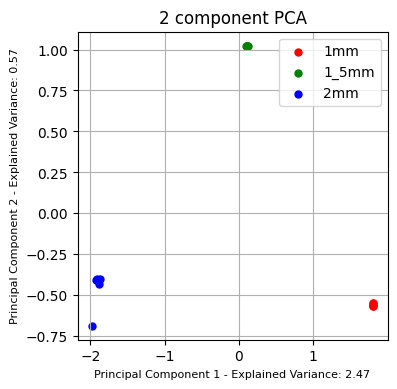

In [9]:
#@title Perform a PCA on the data
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(shifted)
exp = pca.explained_variance_

principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
principalDf['labels'] = labels
s = 4
fig = plt.figure(figsize = (s,s))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(f'Principal Component 1 - Explained Variance: {round(exp[0], 2)}', fontsize = 2*s)
ax.set_ylabel(f'Principal Component 2 - Explained Variance: {round(exp[1], 2)}', fontsize = 2*s)
ax.set_title('2 component PCA', fontsize = 3*s)
#input labels here!
#also change the colors!
labels = ['1mm', '1_5mm', '2mm']
colors = ['r', 'g', 'b']
for label, color in zip(labels,colors):
    indicesToKeep = [label in x for x in principalDf['labels']]
    ax.scatter(principalDf.loc[indicesToKeep, 'PC1'], principalDf.loc[indicesToKeep, 'PC2'], c = color, s = 25)
ax.legend(labels, loc='best')
ax.grid()